In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 70

import statsmodels.api as sm

In [2]:
data = pd.DataFrame({'risk 1': np.random.normal(0, 1, 300),
                     'risk 2': np.random.random(300)})

## SARIMAX

In [5]:
# На основании ACF/PACF
params = {'risk 1': {'p': 1,
                     'd': 1,
                     'q': 1,
                     'freq': 10,
                     'P': 1,
                     'D': 1,
                     'Q': 0},
          'risk 2': {'p': 1,
                     'd': 1,
                     'q': 1,
                     'freq': 10,
                     'P': 1,
                     'D': 1,
                     'Q': 0}}

test_size = 0.1
train_len = int(data.shape[0] * (1 - test_size))

models = {}

for factor in data:
    for param, val in params[factor].items():
        locals()[param] = val

    model = sm.tsa.statespace.SARIMAX(data[factor].iloc[:train_len], order=(p, d, q),
                                      seasonal_order=(P, D, Q, freq))

    model = model.fit()
    models[factor] = model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64801D+00    |proj g|=  1.96948D-01

At iterate    5    f=  1.57978D+00    |proj g|=  3.32969D-02

At iterate   10    f=  1.55950D+00    |proj g|=  1.59745D-02

At iterate   15    f=  1.55576D+00    |proj g|=  8.09953D-03

At iterate   20    f=  1.55544D+00    |proj g|=  3.38987D-04

At iterate   25    f=  1.55539D+00    |proj g|=  2.58437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  4.06815D-01    |proj g|=  4.16556D-02

At iterate   15    f=  3.94170D-01    |proj g|=  2.86782D-02

At iterate   20    f=  3.93098D-01    |proj g|=  8.88660D-03

At iterate   25    f=  3.93000D-01    |proj g|=  9.93739D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     55      2     0     0   7.707D-06   3.930D-01
  F =  0.39299995124535958     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


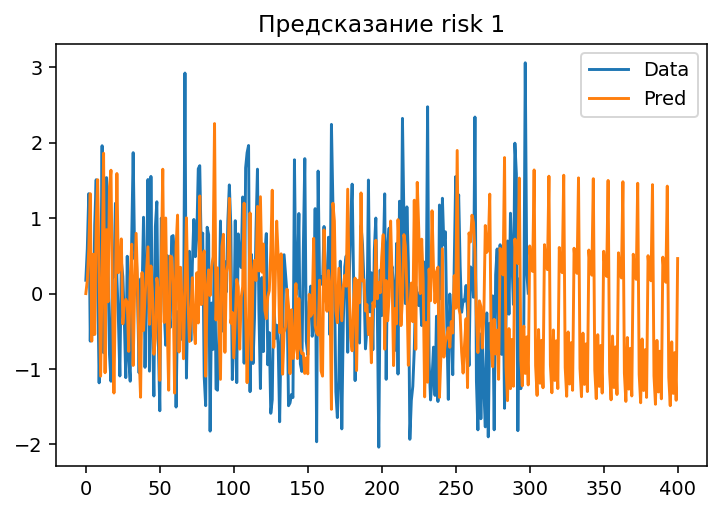

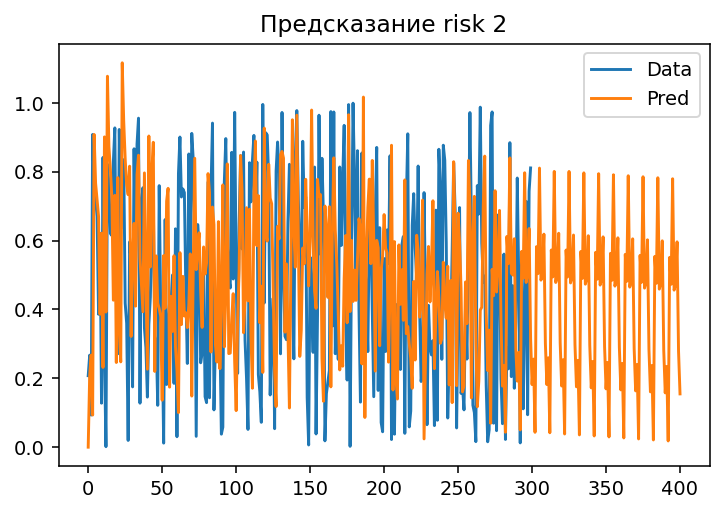

In [6]:
for factor, model in models.items():
    data[factor].plot(label='Data')
    model.predict(0, 400).plot(label='Pred')
    plt.title(f'Предсказание {factor}')
    plt.legend();
    plt.show()

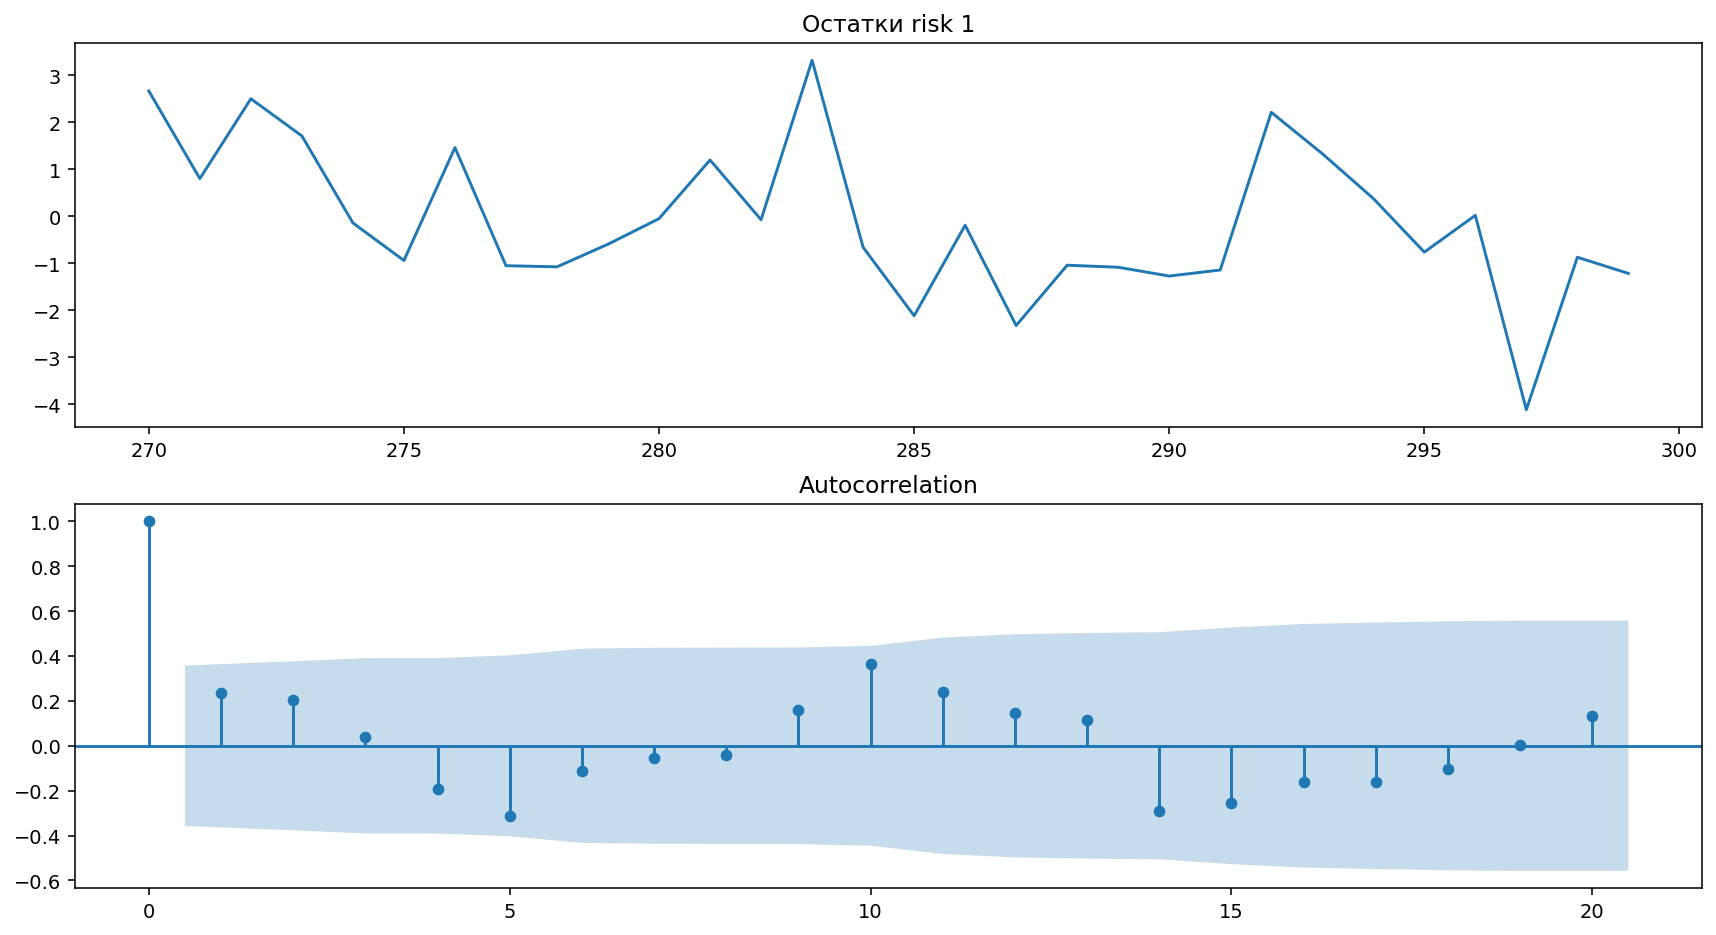

Критерий Дики-Фуллера: p=5.3e-29
На уровне значимости 5% гипотеза о нестационарности отвергается
Критерий Стьюдента: p=0.73
На уровне значимости 5% гипотеза о несмещенности остатков не отвергается
Критерий Вайта: p=0.48
На уровне значимости 5% гипотеза о гомоскедастичности не отвергается


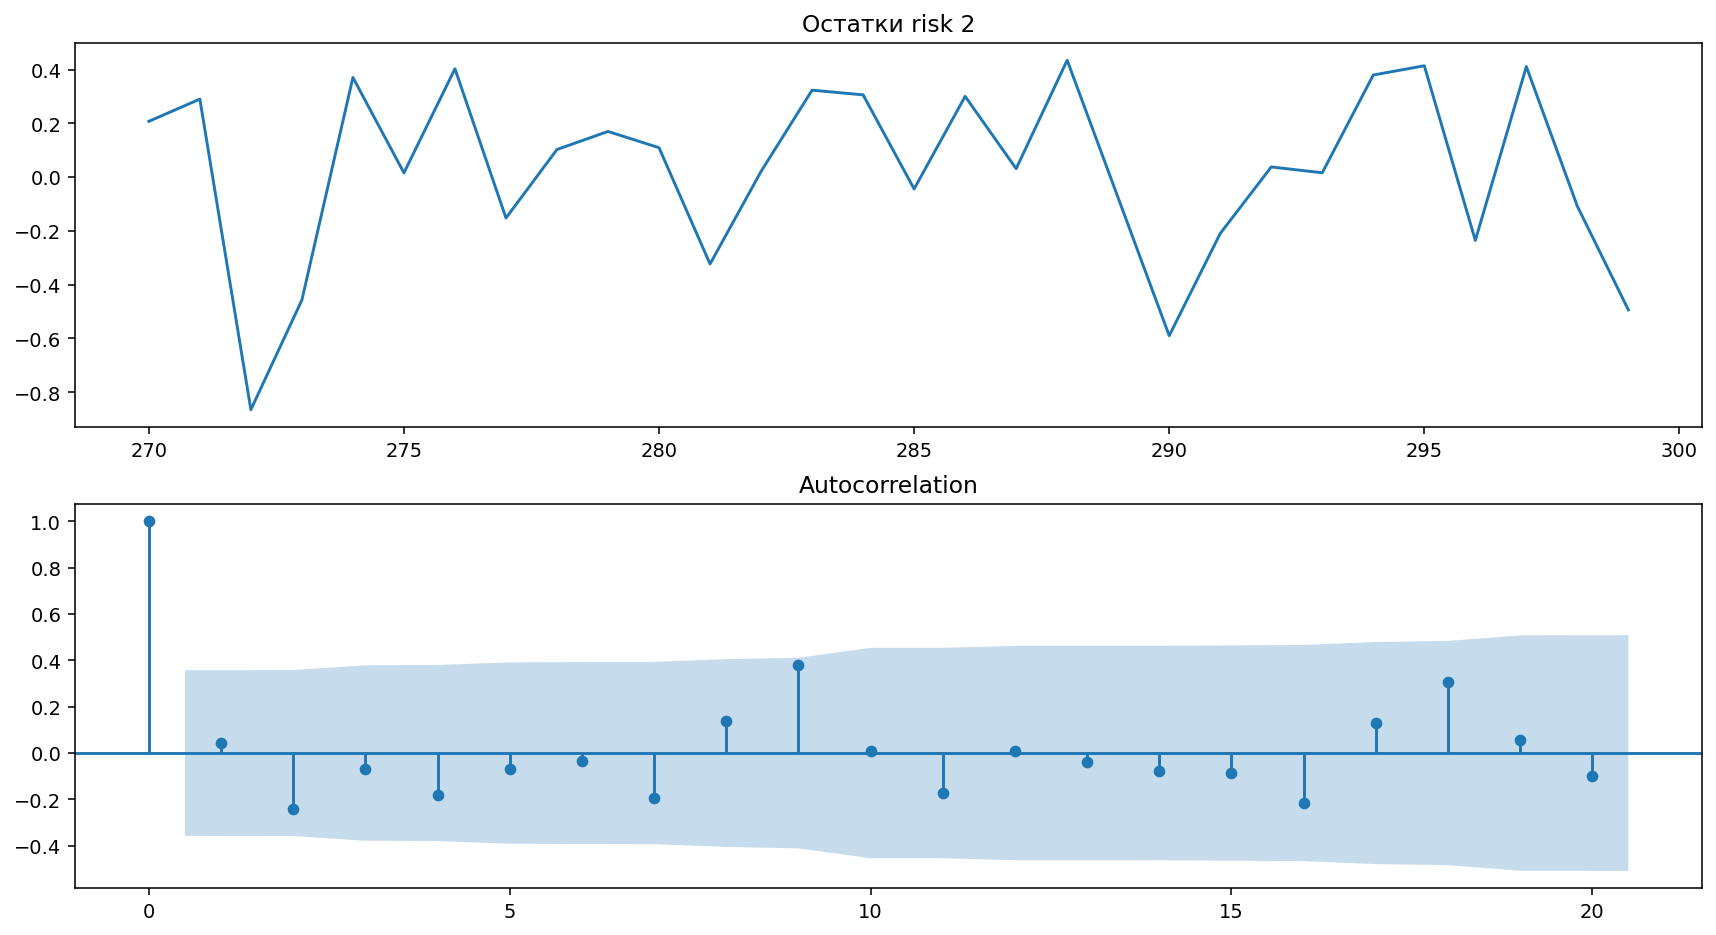

Критерий Дики-Фуллера: p=2.4e-29
На уровне значимости 5% гипотеза о нестационарности отвергается
Критерий Стьюдента: p=0.67
На уровне значимости 5% гипотеза о несмещенности остатков не отвергается
Критерий Вайта: p=0.68
На уровне значимости 5% гипотеза о гомоскедастичности не отвергается


In [39]:
for factor in data:
    pred = models[factor].predict(train_len, data.shape[0]-1)
    target = data[factor].iloc[train_len:]
    resid = pred - target

    plt.figure(figsize=(15,8))
    plt.subplot(211)
    plt.plot(resid)
    plt.title(f'Остатки {factor}')
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_acf(resid, lags=20, ax=ax)
    plt.show()

    pval = sm.tsa.stattools.adfuller(data[factor])[1]
    print(f"Критерий Дики-Фуллера: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о нестационарности '
          + ('отвергается' if pval <= 0.05 else 'не отвергается'))

    pval = st.ttest_1samp(resid, 0)[1]
    print(f"Критерий Стьюдента: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о несмещенности остатков '
          + ('отвергается' if pval <= 0.05 else 'не отвергается'))

    pval = sm.stats.diagnostic.het_goldfeldquandt(resid, resid.values.reshape(-1, 1))[1]
    print(f"Критерий Вайта: p={pval:.2}")
    print('На уровне значимости 5% гипотеза о гомоскедастичности '
          + ('отвергается' if pval <= 0.05 else 'не отвергается'))